# Tutorial 3: Validación con benchmark NAFEMS – Viga trapezoidal sometida a gravedad

En este tutorial resolveremos un problema clásico de la literatura de elementos finitos: una **viga en voladizo de sección variable (trapezoidal)** empotrada en el extremo izquierdo y sometida a la acción de la **gravedad**. Este caso forma parte de los benchmarks de NAFEMS (National Agency for Finite Element Methods and Standards) y está documentado en la página de COMSOL Multiphysics.

El objetivo es doble:

* Aprender a generar una geometría no rectangular utilizando una malla estructurada transformada.
* Validar la solución numérica obtenida comparando el esfuerzo cortante $\tau_{xy}$ en el punto $(0,2)$ con el valor de referencia proporcionado por el benchmark.

## 1. Descripción del problema físico

La geometría de la viga se muestra en la figura: tiene una longitud de $4\,\text{m}$, una altura de $4\,\text{m}$ en el extremo empotrado ($x=0$) y de $2\,\text{m}$ en el extremo libre ($x=4$). El espesor fuera del plano es $t = 0.1\,\text{m}$.

El material es acero con densidad $\rho = 7000\,\text{kg/m}^3$ (dato del benchmark). Aunque el módulo de Young y el coeficiente de Poisson no se especifican en la referencia, se asumen valores típicos: $E = 200\,\text{GPa}$, $\nu = 0.3$ (estos valores no afectan el esfuerzo cortante en este caso de carga gravitatoria, ya que la tensión es independiente de $E$ para cargas de cuerpo).

La viga está **empotrada** en el extremo izquierdo ($x=0$), es decir, todos los desplazamientos ($u_x, u_y$) son nulos en esa cara. Sobre toda la viga actúa la **gravedad** en dirección vertical negativa, con $g = 9.81\,\text{m/s}^2$. La fuerza por unidad de volumen es:

$$
b_x = 0, \qquad b_y = -\rho g = -68670\,\text{N/m}^3
$$

El benchmark proporciona un valor de referencia para el **esfuerzo cortante** $\tau_{xy}$ en el punto $(x,y) = (0, 2)$ (justo en el empotramiento, a media altura):

$$
\tau_{xy,\text{ref}} = -0.200\,\text{MPa}
$$

Este valor fue obtenido con elementos finitos de alta calidad (COMSOL, malla fina, elementos cuadráticos) y se considera la solución de referencia.

## 2. Enlace al benchmark original

La descripción completa del problema (incluyendo el segundo caso de carga, con fuerza horizontal) puede consultarse en la documentación de COMSOL:

[https://doc.comsol.com/6.0/doc/com.comsol.help.models.mph.tapered_cantilever/tapered_cantilever.html](https://doc.comsol.com/6.0/doc/com.comsol.help.models.mph.tapered_cantilever/tapered_cantilever.html)

## 3. Implementación

A continuación se muestra el código completo, dividido en secciones lógicas. Se han eliminado comentarios redundantes para mantener la claridad.

### 3.1 Importación de módulos y definición de parámetros


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from femppp import *   # Clases: FEMProblem, TriangularElement, Tessellation

# Geometría (tomada del benchmark)
length = 4.0          # longitud [m]
H_left = 4.0          # altura en x=0
H_right = 2.0         # altura en x=length
thickness = 0.1       # espesor fuera del plano [m]

# Material (valores asumidos)
E = 200e9             # módulo de Young [Pa]
nu = 0.3              # coeficiente de Poisson
rho = 7000.0          # densidad [kg/m³] (dato del benchmark)
g = 9.81              # gravedad [m/s²]

# Carga de cuerpo
bx = 0.0
by = -rho * g         # [N/m³]



### 3.2 Generación de la malla trapezoidal

Para obtener una malla estructurada que respete exactamente los bordes inclinados, utilizamos una transformación isoparamétrica: generamos primero una malla en un cuadrado unitario $(\xi, \eta) \in [0,1]\times[0,1]$ y luego la mapeamos a la geometría real mediante las expresiones:

* Coordenada horizontal: $x = \text{length} \cdot \xi$
* Borde inferior: recta que une $(0,0)$ con $(4,1)$ → $y_{\text{inf}} = x/4$
* Borde superior: recta que une $(0,4)$ con $(4,3)$ → $y_{\text{sup}} = 4 - x/4$
* Para un $\eta$ dado, la coordenada vertical se interpola linealmente entre ambos bordes:

$$
y = (1-\eta)\,y_{\text{inf}} + \eta\,y_{\text{sup}}
$$


In [23]:
# Resolución de la malla
nxi, neta = 60, 20          # número de divisiones en dirección longitudinal y transversal

xi = np.linspace(0, 1, nxi)
eta = np.linspace(0, 1, neta)
XI, ETA = np.meshgrid(xi, eta)

# Coordenada x
X = length * XI

# Bordes inferior y superior
y_lower = X / 4
y_upper = 4 - X / 4

# Coordenada y por interpolación lineal
Y = (1 - ETA) * y_lower + ETA * y_upper

# Puntos de la malla
points = np.column_stack((X.ravel(), Y.ravel()))



### 3.3 Triangulación y visualización de la malla

Utilizamos la clase `Tessellation` para generar la triangulación de Delaunay sobre los puntos generados. Esto produce una malla no estructurada pero con buena calidad.


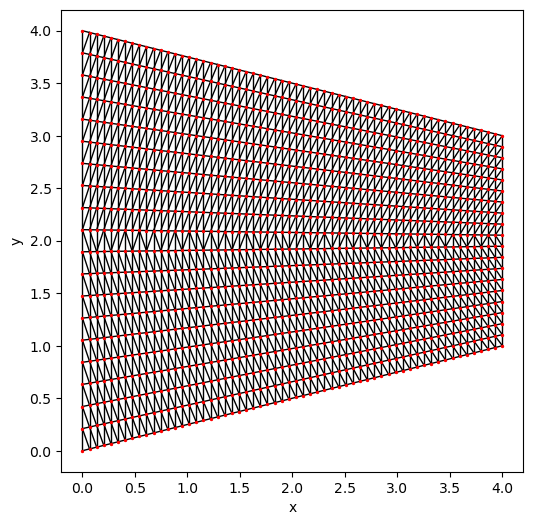

In [24]:
tess = Tessellation(points)
simplices = tess.simplices

# Visualización de la malla
tess.plot(show_node_ids=False, show_element_ids=False, node_size=2, figure_size=(9,6))



### 3.4 Creación de los elementos finitos (CST)

Creamos un objeto `TriangularElement` para cada triángulo de la malla.


In [25]:
elements = []
for tri_nodes in simplices:
    elem = TriangularElement(
        node_ids=tri_nodes,
        nodes=points,
        E=E,
        nu=nu,
        thickness=thickness,
        element_type="CST"
    )
    elements.append(elem)

print(f"Nodos: {points.shape[0]}, Elementos: {len(elements)}")


Nodos: 1200, Elementos: 2242


### 3.5 Ensamblaje y condiciones de contorno

Construimos el problema, ensamblamos la matriz de rigidez y aplicamos las condiciones:

* **Empotramiento izquierdo**: todos los nodos con $x \approx 0$ tienen $u_x = u_y = 0$
* **Carga de gravedad**: se aplica como fuerza de cuerpo mediante `apply_body_force`


In [26]:
problem = FEMProblem(elements)
problem.assemble_stiffness()

# Nodos del extremo izquierdo
tol = 1e-8
left_nodes = np.where(np.abs(points[:, 0]) < tol)[0]
print(f"Nodos empotrados: {len(left_nodes)}")

# Fijar desplazamientos nulos
dirichlet_values = np.zeros((len(left_nodes), 2))
problem.apply_dirichlet_bcs(left_nodes, dirichlet_values)

# Carga de gravedad
problem.apply_body_force(bx, by)


Nodos empotrados: 20


### 3.6 Solución del sistema

Resolvemos el sistema lineal mediante un solver directo y calculamos las tensiones en los elementos.


In [9]:
problem.solve(method='direct')
problem.compute_element_stresses()

### 3.7 Visualización de resultados

Mostramos la deformada amplificada y la distribución de la tensión de von Mises.


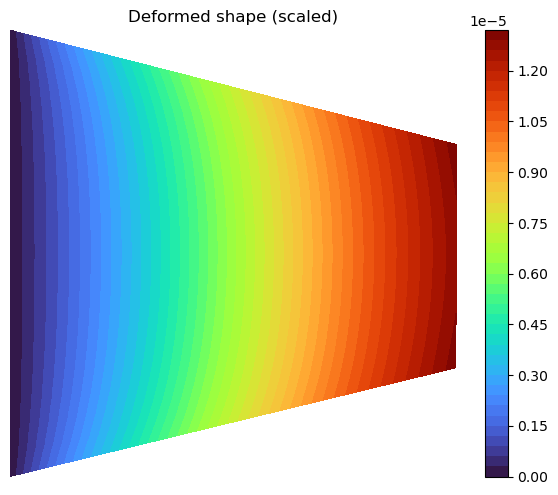

In [11]:
# Contorno deformado (escala 2000x)
plot_deformed_contour(
    tess.points,
    tess.simplices,
    problem.ux,
    problem.uy,
    scale=2000
)


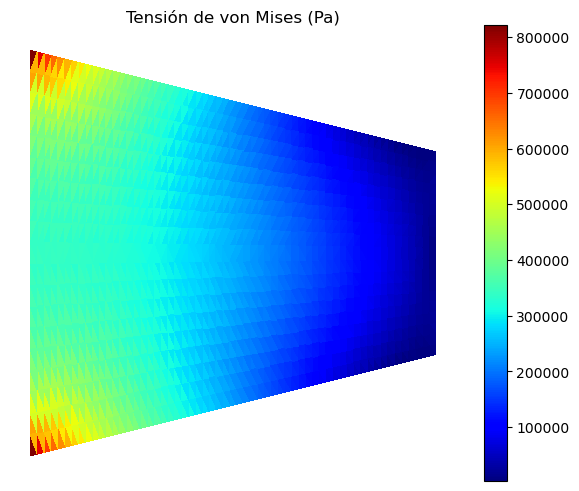

In [12]:
# Tensión de von Mises por elemento
problem.plot_elemental_variable(
    tess.points,
    tess.simplices,
    problem.sigma_vm,
    title="Tensión de von Mises (Pa)"
)


### 3.8 Extracción del esfuerzo cortante en el punto (0,2)

El benchmark reporta el valor de $\tau_{xy}$ en el punto $(0,2)$. Dado que las tensiones son constantes por elemento, aproximamos el valor en el punto mediante la tensión del elemento cuyo centroide esté más cercano.


In [13]:
# Punto de evaluación
x_target, y_target = 0.0, 2.0

# Centroides de los elementos
centroids = np.array([np.mean(points[elem.node_ids], axis=0) for elem in elements])

# Distancia al punto objetivo
dist = np.linalg.norm(centroids - [x_target, y_target], axis=1)
elem_idx = np.argmin(dist)

tau_xy_fem = problem.tau_xy[elem_idx]   # τ_xy del elemento más cercano


### 3.9 Comparación con el valor de referencia


In [14]:
tau_ref_mpa = -0.200        # MPa (benchmark)
tau_fem_mpa = tau_xy_fem / 1e6

print("\n" + "="*60)
print(" VALIDACIÓN CON BENCHMARK NAFEMS - VIGA TRAPEZOIDAL (GRAVEDAD)")
print("="*60)
print(f"  Esfuerzo cortante τ_xy en (0, 2):")
print(f"    - COMSOL / NAFEMS (ref): {tau_ref_mpa:.6f} MPa")
print(f"    - FEM (CST, este código): {tau_fem_mpa:.6f} MPa")
print(f"    - Error absoluto: {abs(tau_fem_mpa - tau_ref_mpa):.3f} MPa")
print(f"    - Error relativo: {abs((tau_fem_mpa - tau_ref_mpa)/tau_ref_mpa)*100:.1f}%")
print("="*60)



 VALIDACIÓN CON BENCHMARK NAFEMS - VIGA TRAPEZOIDAL (GRAVEDAD)
  Esfuerzo cortante τ_xy en (0, 2):
    - COMSOL / NAFEMS (ref): -0.200000 MPa
    - FEM (CST, este código): -0.200144 MPa
    - Error absoluto: 0.000 MPa
    - Error relativo: 0.1%


## 4. Estudio de convergencia (opcional)

Podemos repetir el análisis con diferentes refinamientos para observar cómo disminuye el error al aumentar el número de elementos. A continuación se muestra un código que automatiza este estudio y genera una tabla de convergencia.


In [15]:
refinements = [
    (20, 6),
    (30, 10),
    (40, 14),
    (50, 18),
    (60, 22)
]

results = []

for nxi, neta in refinements:
    print(f"\n--- Malla: nxi={nxi}, neta={neta} ---")
    
    # Generar puntos
    xi = np.linspace(0, 1, nxi)
    eta = np.linspace(0, 1, neta)
    XI, ETA = np.meshgrid(xi, eta)
    X = length * XI
    y_lower = X / 4
    y_upper = 4 - X / 4
    Y = (1 - ETA) * y_lower + ETA * y_upper
    points = np.column_stack((X.ravel(), Y.ravel()))
    
    tess = Tessellation(points)
    
    # Crear elementos
    elements = []
    for tri in tess.simplices:
        elements.append(TriangularElement(
            node_ids=tri, nodes=points,
            E=E, nu=nu, thickness=thickness, element_type="CST"
        ))
    
    # Ensamblar y resolver
    problem = FEMProblem(elements)
    problem.assemble_stiffness()
    
    left_nodes = np.where(np.abs(points[:,0]) < 1e-8)[0]
    problem.apply_dirichlet_bcs(left_nodes, np.zeros((len(left_nodes),2)))
    problem.apply_body_force(bx, by)
    problem.solve(method='direct')
    problem.compute_element_stresses()
    
    # Extraer τ_xy en (0,2)
    centroids = np.array([np.mean(points[elem.node_ids], axis=0) for elem in elements])
    dist = np.linalg.norm(centroids - [0,2], axis=1)
    tau_fem = problem.tau_xy[np.argmin(dist)] / 1e6
    error = abs((tau_fem - tau_ref_mpa) / tau_ref_mpa) * 100
    
    results.append({
        'nxi': nxi, 'neta': neta,
        'nodos': tess.n_nodes,
        'elementos': tess.n_elements,
        'τxy (MPa)': tau_fem,
        'error (%)': error
    })

# Mostrar tabla
df = pd.DataFrame(results)
print("\nTabla de convergencia:")
df



--- Malla: nxi=20, neta=6 ---

--- Malla: nxi=30, neta=10 ---

--- Malla: nxi=40, neta=14 ---

--- Malla: nxi=50, neta=18 ---

--- Malla: nxi=60, neta=22 ---

Tabla de convergencia:


,nxi,neta,nodos,elementos,τxy (MPa),error (%)
0,20,6,120,309,-0.198101,0.949616
1,30,10,300,821,-0.200330,0.164906
2,40,14,560,1573,-0.199672,0.163920
3,50,18,900,2565,-0.200661,0.330324
4,60,22,1320,3797,-0.199723,0.138396


### 4.1 Gráfico de convergencia

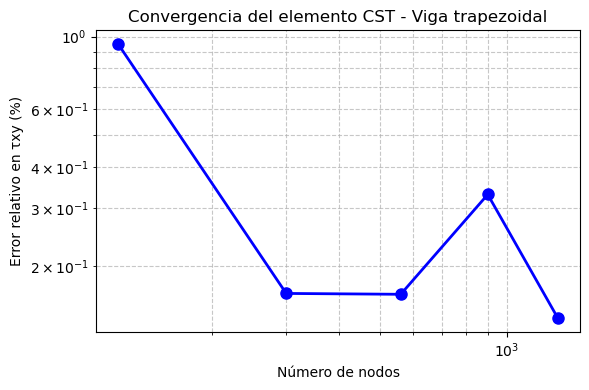

In [16]:
plt.figure(figsize=(6,4))
plt.loglog(df['nodos'], df['error (%)'], 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de nodos')
plt.ylabel('Error relativo en τxy (%)')
plt.title('Convergencia del elemento CST - Viga trapezoidal')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()